{'BATCH_SIZE': 1, 'NUM_BF': 3, 'NUM_DF': 13, 'FEAT_DIM': 32, 'NUM_WORKERS': 32, 'EPOCHS_NUM': 810, 'LR': 1e-05, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 0, 'LR_DISC': 1e-06, 'WEIGHT_DISC': 0, 'WEIGHT_TV': 0, 'WEIGHT_FORWARD': 0, 'WEIGHT_STAIN': 1, 'TRAIN_SIZE': 551, 'TEST_SIZE': 8, 'VALID_SIZE': 551, 'MODE': 'inference', 'SAVE_SUBITER': 100, 'TRAIN_MODE': 'ENTIRE'}
Inference Start!
start save


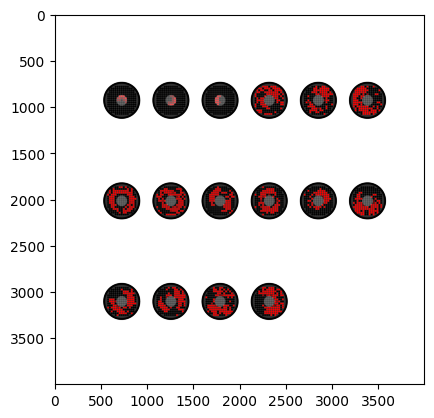

end save
15.396676
0.3446979559547794
0.038479992350585135


In [3]:

import math
import scipy.io
import numpy as np
import torchvision.transforms as transforms
import torch
import torch.optim as optim
import datetime
import wandb
import models

from FPM_recon_dataset_RED import FPM_recon_dataset_RED
from FPM_dataset_RED import FPM_dataset_RED
import matplotlib.pyplot as plt

import time
import imageio
import visualizer
from PIL import Image
import io
from utils import *

from skimage.exposure import match_histograms
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error



# Notation for individual wandb log name
NOTES = 'train'

# Define network hyperparameters:
HPARAMS = {
    'BATCH_SIZE': 1,
    'NUM_BF': 3,
    'NUM_DF': 13,
    'FEAT_DIM': 32,
    'NUM_WORKERS': 32,
    'EPOCHS_NUM': 810,
    'LR': 0.00001,
    'MOMENTUM': 0.9,
    'WEIGHT_DECAY' : 0,
    'LR_DISC' : 0.000001,
    'WEIGHT_DISC' : 0, #1e-1 1e+3
    'WEIGHT_TV':0,
    'WEIGHT_FORWARD':0,#1e-2
    'WEIGHT_STAIN' : 1,
    'TRAIN_SIZE':551,#384
    'TEST_SIZE':8,
    'VALID_SIZE':551,#551
    'MODE' : 'inference', #'inference' train
    'SAVE_SUBITER':100,
    'TRAIN_MODE':'ENTIRE' # 'RECON', 'STAIN', 'ENTIRE'
    
}


# LR_LED = HPARAMS['LR'] * 1e+3
# # LR_HEAD = HPARAMS['LR'] * 1e+1
# # LR_BODY = HPARAMS['LR'] * 1e+1
# # LR_TAIL = HPARAMS['LR'] * 1e+1
# LR_CONTRASTIVE = HPARAMS['LR'] * 1e-2

## end2end
LR_LED = HPARAMS['LR'] * 1e+3
LR_HEAD = HPARAMS['LR'] * 1e+0
LR_BODY = HPARAMS['LR'] * 1e+0
LR_TAIL = HPARAMS['LR'] * 1e+0
LR_CONTRASTIVE = HPARAMS['LR'] * 0


print(HPARAMS)
## stain
## wo discriminator

name_weight_disc = 'disc_valid_20230731_102450_00400'

## forward model
#slide 32
# name_weight_stain='stain_20240523_053356_00500'
# name_weight_recon='recon_20240523_053356_00100' 

#slide 34
# name_weight_stain='stain_20240524_165751_00500'
# name_weight_recon='recon_20240524_165751_00100' ## w/o/ forward

#slide 15
# name_weight_stain='recon_20240529_004020_00300'
# name_weight_recon='stain_20240529_004020_00300' ## w/o/ forward


##reference
# name_weight_stain='stain_20240529_004020_00300'
# name_weight_recon='recon_20240529_004020_00300' ## reference


#bladder
# name_weight_stain='stain_20240607_130234_00600'
# name_weight_recon='recon_20240607_130234_00600' ## w/o/ forward

#stomach
# name_weight_stain = 'stain_20240605_224330_00600'
# name_weight_recon = 'recon_20240605_224330_00600' ## w/o/ forward

#stomach/bladder
# name_weight_stain='stain_20240619_050050_00600'
# name_weight_recon='recon_20240619_050050_00600' ## w/o/ forward



## LED
# ## led 32
# name_weight_stain='stain_20240619_050050_00600'
# name_weight_stain='stain_20241113_114121_00400'
# name_weight_recon='recon_20240627_020315_00400' ## w/o/ forward

# ## led 16
# name_weight_stain='stain_20240605_224330_00600'
# name_weight_recon='recon_20240605_224330_00600' ## w/o/ forward

# ## led 12
# name_weight_stain='stain_20240626_145525_00400'
# name_weight_stain='stain_20241113_114121_00400'
# name_weight_recon='recon_20240626_145525_00400' ## w/o/ forward

# ## led 8
# name_weight_stain='stain_20240626_004723_00400'
# name_weight_stain='stain_20241113_114121_00400'
# name_weight_recon='recon_20240626_004723_00400' ## w/o/ forward

## led 3
# name_weight_stain='stain_20240625_101111_00400'
# name_weight_stain='stain_20241113_114121_00400'
# name_weight_recon='recon_20240625_101111_00400' ## w/o/ forward

## single layer
# name_weight_stain='stain_20240629_151745_00500'
# name_weight_recon='recon_20240724_155130_00800' 

## wo led optimization
# name_weight_recon = 'recon_20241018_182823_00800'
# name_weight_stain = 'stain_20241018_182823_00800'

## GAN
# name_weight_stain = 'stain_20240627_150040_00400'
# name_weight_recon = 'recon_20240627_150040_00400'


#stomach
# name_weight_stain = 'stain_20240623_150355_00600'
# name_weight_recon = 'recon_20240623_150355_00600' ## w/o/ forward

## stomach _ new
# name_weight_stain = 'stain_20241023_175631_00500'
# name_weight_recon = 'recon_20241023_175631_00500' ## w/o/ forward

## bladder
# name_weight_stain = 'stain_20241024_123427_00600'
# name_weight_recon = 'recon_20241024_123427_00600' ## w/o/ forward

## wo
# name_weight_stain = 'stain_20241025_051736_00300'
# name_weight_recon = 'recon_20241025_051736_00300' ## w/o/ forward


## enlarge feature
# name_weight_stain = 'stain_20241029_085915_00200'
# name_weight_recon = 'recon_20241029_085915_00200' ## w/o/ forward

## large dataset
# name_weight_stain = 'stain_20241029_145339_00300'
# name_weight_recon = 'recon_20241029_145339_00300' ## w/o/ forward


# name_weight_stain = 'stain_20241031_150744_00200'
# name_weight_recon = 'recon_20241031_150744_00200' ## w/o/ forward


## 1e+3 mse
# name_weight_stain = 'stain_20241031_192350_00100'
# name_weight_recon = 'recon_20241031_192350_00100' ## w/o/ forward

## 1e+2 cross
# name_weight_stain = 'stain_20241031_215436_00300'
# name_weight_recon = 'recon_20241031_215436_00300' ## w/o/ forward

## bladder
# name_weight_stain = 'stain_20241031_215955_00300'
# name_weight_recon = 'recon_20241031_215955_00300' ## w/o/ forward

## 1e+4
# name_weight_stain = 'stain_20241031_215436_00300'
# name_weight_recon = 'recon_20241031_215436_00300' ## w/o/ forward


## bladder 1e+1
# name_weight_stain = 'stain_20241101_071029_00100'
# name_weight_recon = 'recon_20241101_071029_00100' ## w/o/ forward

## phase bladder
# name_weight_stain = 'stain_20241101_071308_00200'
# name_weight_recon = 'recon_20241101_071308_00200' ## w/o/ forward

## bladder 1e+3 w/ phase bladder
# name_weight_stain = 'stain_20241101_113530_00100'
# name_weight_recon = 'recon_20241101_113530_00100' ## w/o/ forward

# ## phase recon more + 1e+3
# name_weight_stain = 'stain_20241102_094523_00200'
# name_weight_recon = 'recon_20241102_094523_00200' ## w/o/ forward

# ## phase recon more + 1e+4
# name_weight_stain = 'stain_20241102_171526_00500'
# name_weight_recon = 'recon_20241102_171526_00500' ## w/o/ forward


# ## phase recon more +0e+0
# # name_weight_stain = 'stain_20241103_113002_00400'
# # name_weight_recon = 'recon_20241103_113002_00400' ## w/o/ forward

# ## phase recon more +0e+0
# # name_weight_stain = 'stain_20241104_001721_00400'
# # name_weight_recon = 'recon_20241104_001721_00400' ## w/o/ forward


# # ## stomach final
name_weight_stain = 'stain_20241113_114121_00100'
name_weight_recon = 'recon_20241113_114121_00100' ## w/o/ forward

# ## bladder final
# name_weight_stain = 'stain_20241113_113614_00300'
# name_weight_recon = 'recon_20241113_113614_00300' ## w/o/ forward


# ## bladder phase (fin final)
# name_weight_stain = 'stain_20241118_132616_00500'
# name_weight_recon = 'recon_20241118_132616_00500' ## w/o/ forward

# ## bladder ongoing 1(fin final)
# name_weight_stain = 'stain_20250219_123438_00300'
# name_weight_recon = 'recon_20250219_123438_00300' ## w/o/ forward

# ## bladder ongoing 2(fin final)
# name_weight_stain = 'stain_20250220_110313_00300'
# name_weight_recon = 'recon_20250220_110313_00300' ## w/o/ forward

# # # ## stomach final feature 4
# # name_weight_stain = 'stain_20250221_102457_00400'
# # name_weight_recon = 'recon_20250221_102457_00400' ## w/o/ forward

# # # ## stomach final feature 256
# name_weight_stain = 'stain_20250222_162110_00100'
# name_weight_recon = 'recon_20250222_162110_00100' ## w/o/ forward



# # ## bladder ongoing 3(fin final)
# name_weight_stain = 'stain_20250220_110111_00600'
# name_weight_recon = 'recon_20250220_110111_00600' ## w/o/ forward





TPARAMS = {}
IMAGE_SHAPE = (193, 200, 200)
IMAGE_SHAPE_INTER = (1, 600, 600)

# for model save, use time for data name variation
START_DATE = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  

# baseDir="/home/kcl724/data/data3/KC/virtual_staining/"
baseDir = "/mnt/data3/KC/virtual_staining/"
images_raw=[]
images_raw_valid=[]
images_raw_test=[]
# images_raw.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/02.sto_S_15-71892_sec1/R/Dataset/')
# images_raw.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/15.bladder_S_A4_23-36533_sec1/R/Dataset/')
# images_raw.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/14.bladder_S_A1_23-36533_sec1/R/Dataset/')
images_raw.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/22.sto_S_A3 18-37852_sec1/R/Dataset/')


# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/38.bla_U_A12_23-35177_sec1/R/Dataset/')

# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/14.bladder_S_A1_23-36533_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/34.bla_U_A4 23-36533_sec2/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/44.bla_F3_A1_23-36533_sec2/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/22.sto_S_A3 18-37852_sec1/R/Dataset/')


# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/xx. phase_target/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/35.sto_U_A3_16-68231_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/36.sto_U_A3_16-68231_sec2/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/22.sto_S_A3 18-37852_sec1/R/Dataset/')

# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/32.sto_S2F(U)_A3 18-37852_sec1(pair22)/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/33.sto_U_A3 16-68231_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/34.bla_U_A4 23-36533_sec2/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/02.sto_S_15-71892_sec1/R/Dataset/')

# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/37.sto_U_A3_16-68231_sec3/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/38.bla_U_A12_23-35177_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/39.sto_F1_A3_16-68731_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/40.sto_F3_A3_18-37852_sec2/R/Dataset/')
images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/41.sto_F1_A3_18-37852_sec3/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/42.sto_F3_A3_18-37852_sec4/R/Dataset/')



# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/14.bladder_S_A1_23-36533_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/43.bla_F3_A1_23-36533_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/44.bla_F3_A1_23-36533_sec2z/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/46.bla_U_A4_23-36533_sec4/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/45.bla_U_A4_23-36533_sec3/R/Dataset/')





# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/18.sto_F_15-71892_sec3/R/Dataset/')


# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/19.bladder_F_SS16-06440_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/33.sto_U_A3 16-68231_sec1/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/34.bla_U_A4 23-36533_sec2/R/Dataset/')
# images_raw_valid.append('/home/kcl724/data/data3/FPM_com/tissue NIR dataset/02.sto_S_15-71892_sec1/R/Dataset/')


if HPARAMS['MODE'] =='train':
    wandb.login()
    wandb.init(project=HPARAMS['TRAIN_MODE'],
               config=HPARAMS,
               name='rack_'+START_DATE,
               dir =baseDir+'wandb',
               # mode='disabled',
               notes=NOTES)

if HPARAMS['MODE'] =='inference':
    currdate=datetime.datetime.today().strftime("%Y%m%d%H%M%S")
    save_img_dir=baseDir+'imgs/'+currdate+'_'+name_weight_stain+'_'+name_weight_disc+'/'    
    

save_weight_dir=baseDir+"weights/"



def quantize_to_L_levels(x: torch.Tensor, L: int, minmax: str = "tensor"):
    """
    Uniform quantization to L levels over [xmin, xmax].
    minmax='tensor' uses global min/max of x; 'unit' assumes [0,1]; 'symmetric' uses max(|x|).
    """
    if minmax == "unit":
        xmin, xmax = 0.0, 1.0
    elif minmax == "symmetric":
        a = x.detach().abs().max()
        xmin, xmax = -a, a
    else:  # 'tensor'
        xmin = x.detach().min()
        xmax = x.detach().max()

    # avoid degenerate range
    scale = (xmax - xmin).clamp(min=1e-12) / (L - 1)
    q = torch.round((x - xmin) / scale) * scale + xmin
    return q

def save_imgs(parameters,saveDir):

#     q = quantize_to_L_levels(parameters['model_recon'].led_weights, L=16)  # returns a Tensor
#     parameters['model_recon'].led_weights = torch.nn.Parameter(q)   
    
    q = (torch.clamp(parameters['model_recon'].led_weights, 0,1))
    parameters['model_recon'].led_weights = torch.nn.Parameter(quantize_to_L_levels(q, L=16))  # 16 uniform levels
    # parameters['model_recon'].led_weights = torch.nn.Parameter(q)  # 16 uniform levels
    
    
    
    
    # parameters['model_recon'].led_weights = 
    result = {} 
    maxVal_phase = 0
    minVal_phase = 0
    count = 0
    for i, (data_unstained, target_unstained, cropR_unstained) in enumerate(parameters['validset_loader']):
        if i in range(273,278):
            data_unstained,target_unstained = data_unstained.to(DEVICE),target_unstained.to(DEVICE)
            output_recon, img_opt = parameters['model_recon'](data_unstained)
            
            # maxVal_phase = maxVal_phase + torch.max(target_unstained[:,3,:,:])
            # minVal_phase = minVal_phase + torch.min(target_unstained[:,3,:,:])
            maxVal_phase = maxVal_phase + torch.max(output_recon[:,0,:,:])
            minVal_phase = minVal_phase + torch.min(output_recon[:,0,:,:])
            count = count + 1
    
    maxVal_phase=maxVal_phase/count
    minVal_phase=minVal_phase/count
    maxVal_stain=torch.tensor(1)
    
    # maxVal_phase=torch.tensor(0.8)
    # minVal_phase=torch.tensor(-0.3)

    mode = 'entire'
    os.makedirs(saveDir+'stain/')
    os.makedirs(saveDir+'phase/')    
    os.makedirs(saveDir+'mat/')
    os.makedirs(saveDir+'leds/')
    print('start save')
    
    
    leds=led_visualize(parameters)
    plt.figure()
    plt.imshow(leds)
    plt.show()
    
    for i in range (HPARAMS['NUM_BF']+HPARAMS['NUM_DF']):
        leds=led_visualize_individual(parameters, i)
        imageio.imwrite(saveDir+'leds/'+ 'led_{0:03d}'.format(i)+'.png', leds)

        
    
    psnr_array = []
    ssim_array = []
    mse_array = []
    if mode == 'entire':
        parameters['model_stain'].eval()
        parameters['model_recon'].eval()
        with torch.no_grad():
            
            for i, (data_unstained, target_unstained, cropR_unstained) in enumerate(parameters['validset_loader']):
                data_unstained,target_unstained = data_unstained.to(DEVICE),target_unstained.to(DEVICE)
                output_recon, img_opt = parameters['model_recon'](data_unstained)
                # temp = output_recon[:,0,:,:] * 6
                # print(torch.min(temp))
                # print(torch.max(temp))
                # temp = temp *(temp<=3.14) * (temp>-3.14) + (temp+3.14)*(temp <= -3.14) + (temp-3.14)*(temp > 3.14)
                # print(torch.min(temp))
                # print(torch.max(temp))
                output_stain_unstained,f1 = parameters['model_stain']((output_recon[:,0,:,:]).view(-1,1,600,600))
                # output_stain_unstained,f1 = parameters['model_stain']((target_unstained[:,3,:,:]).view(-1,1,600,600))
                
                # output_stain_unstained,f1 = parameters['model_stain'](temp.view(-1,1,600,600))
                # print(torch.max(output_stain_unstained))
                # print(torch.min(output_stain_unstained))
                
                



                
                

                # unstain tissue processing                    
                result_phase_unstained = output_recon[:,0,:,:].view(-1,1,600,600).squeeze(0).squeeze(0)
                # result_phase_unstained = target_unstained[:,3,:,:].view(-1,1,600,600).squeeze(0).squeeze(0)
                
                # result_phase_unstained = temp.view(-1,1,600,600).squeeze(0).squeeze(0)    
                result_stain_unstained = output_stain_unstained.view(-1,3,600,600).squeeze(0)
                result_phase_unstained = minmax_norm_number(result_phase_unstained,maxVal_phase,minVal_phase).detach().cpu().numpy()
                # result_phase_unstained = minmax_norm_number(result_phase_unstained,torch.max(result_phase_unstained),torch.min(result_phase_unstained)).detach().cpu().numpy()

                result_stain_unstained = minmax_norm_number(result_stain_unstained,maxVal_stain,0).detach().cpu().numpy()
                # result_stain_unstained = minmax_norm_number(result_stain_unstained,2,-2).detach().cpu().numpy()
                result_stain_unstained = alt_axis(result_stain_unstained)
                
                # plt.figure()
                # plt.subplot(1,2,1)
                # plt.imshow(result_phase_unstained,cmap='gray')
                # plt.colorbar()
                # plt.subplot(1,2,2)
                # plt.imshow(result_stain_unstained)
                # plt.colorbar()
                # plt.show()
                
                res_temp = output_recon[:,0,:,:].squeeze(0).detach().cpu().numpy()
                ref_temp = target_unstained[:,3,:,:].squeeze(0).detach().cpu().numpy()
                
                
                res = tensor_norm_double(output_recon[:,0,:,:].unsqueeze(1))
                ref = tensor_norm_double(target_unstained[:,3,:,:].unsqueeze(1))
                
                
                data_range = 1.0
                psnr_array.append(PSNR(res, ref))
                # psnr_array.append(peak_signal_noise_ratio(res, ref, data_range = data_range))
                ssim_array.append(structural_similarity(res.squeeze(0).squeeze(0).detach().cpu().numpy(), ref.squeeze(0).squeeze(0).detach().cpu().numpy(), data_range = data_range))
                mse_array.append(mean_squared_error(res_temp, ref_temp))
                
                imageio.imwrite(saveDir+'stain/'+ 'stain_unstained_{0:03d}'.format(i)+'.jpg',(result_stain_unstained*255).astype(np.uint8))
                imageio.imwrite(saveDir+'phase/'+ 'phase_unstained_{0:03d}'.format(i)+'.jpg',(result_phase_unstained*255).astype(np.uint8))
                
    
    elif mode =='stain':
        # parameters['model_stain'].eval()
        parameters['model_recon'].eval()
        with torch.no_grad():
            for i, (data_unstained, target_unstained,cropR_unstained) in enumerate(parameters['validset_loader']):
                data_unstained,target_unstained = data_unstained.to(DEVICE),target_unstained.to(DEVICE)
                output_stain_unstained = parameters['model_recon'](data_unstained)
                # unstain tissue processing                    
                result_phase_unstained=target_unstained[:,3,:,:].view(-1,1,600,600).squeeze(0).squeeze(0)    
                result_stain_unstained=output_stain_unstained.view(-1,3,600,600).squeeze(0)
                result_phase_unstained=minmax_norm_number(result_phase_unstained,maxVal_phase,minVal_phase).detach().cpu().numpy()
                result_stain_unstained=minmax_norm_number(result_stain_unstained,maxVal_stain,0).detach().cpu().numpy()
                result_stain_unstained=alt_axis(result_stain_unstained)



                imageio.imwrite(saveDir+'stain/'+ 'stain_unstained_{0:03d}'.format(i)+'.png',(result_stain_unstained*255).astype(np.uint8))
                imageio.imwrite(saveDir+'phase/'+ 'phase_unstained_{0:03d}'.format(i)+'.png',(result_phase_unstained*255).astype(np.uint8))

                scipy.io.savemat(saveDir+'mat/'+'result_{0:03d}'.format(i)+'.mat',{"stain_unstained":result_stain_unstained,"phase_unstained":result_phase_unstained})
    print('end save')
    # print(psnr_array)
    print(np.mean(psnr_array))
    print(np.mean(ssim_array))
    print(np.mean(mse_array))
    
    
def PSNR(img1, img2):
    mse = torch.mean((img1 - img2) ** 2, dim=(1,2,3), keepdim=True)
    if torch.mean(mse) == 0:
        return "Same Image"
    return torch.mean(10 * torch.log10(1. / mse)).detach().cpu().numpy()
    
    
class LossFunction():
    """Loss function class for multiple loss function."""

    def __init__(self):
        self.criterion_mse = torch.nn.MSELoss().to(DEVICE)
        self.criterion_l1 = torch.nn.L1Loss().to(DEVICE)
        self.CrossEntropyLoss=torch.nn.CrossEntropyLoss().to(DEVICE)
        
        

    def forward(self, output, label, mode, epoch=0):
        if mode=='l1':
            l1_loss = self.criterion_l1(output, label)
            loss = l1_loss
        elif mode=='mse':
            mse_loss = self.criterion_mse(output, label)
            loss = mse_loss
        elif mode=='BCE':
            BCELoss = self.CrossEntropyLoss(output, label)
            loss = BCELoss
        return loss

def data_sampler(dataset,train_size,test_size,mode='train'):
    """data sampling function
    Note:
        
    Args:
        dataset
        train_size
        test_size
        
    Returns:
        train_loader
        test_loader
    """
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if mode =='train':
         
        np.random.shuffle(indices)
        train_indices, test_indices = indices[:train_size], indices[train_size:train_size+test_size]
        # train_sampler=train_indices
        
        train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
        test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)


        train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=HPARAMS['BATCH_SIZE'],
                                               num_workers=HPARAMS['NUM_WORKERS'],
                                               sampler=train_sampler,
                                               # drop_last=True, shuffle=False
                                                  )
        test_loader = torch.utils.data.DataLoader(dataset,
                                                  batch_size=HPARAMS['BATCH_SIZE'],
                                                  num_workers=HPARAMS['NUM_WORKERS'],
                                                  sampler=test_sampler,
                                                  # shuffle=False
                                                  )

    elif mode =='inference':
        train_indices=indices
        train_loader = torch.utils.data.DataLoader(dataset,
                                               batch_size=HPARAMS['BATCH_SIZE'],
                                               num_workers=HPARAMS['NUM_WORKERS'],
                                               sampler=train_indices
                                                  )
        test_loader = train_loader
        
    return train_loader,test_loader



    
def train_recon(train_parameters,mode='train'):

    result = {}
    result['loss_recon_sum'] = 0
    result['output']=0

    if mode=='train':
        train_parameters['model_recon'].train()
        # train_parameters['model_recon'].mask_led=train_parameters['model_recon'].mask_led.to(DEVICE)
        
        for i, (data, target, cropR) in enumerate(train_parameters['trainset_loader']):

            data, target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)

            train_parameters['optimizer_recon'].zero_grad()
            output_recon = train_parameters['model_recon'](data)

            loss_phase = train_parameters['loss_function'].forward(output_recon[:,0,:,:], target[:,3,:,:],'l1')
            loss_amp = train_parameters['loss_function'].forward(output_recon[:,1,:,:], target[:,4,:,:],'l1')

            
            loss_recon = loss_phase #+ loss_amp
            if train_parameters['WEIGHT_FORWARD']>0:
                output_raw_crop = TPARAMS['model_forward_crop'].forward(output_recon[:,0,:,:],output_recon[:,1,:,:],cropR,TPARAMS['low_pass_filt'])
                output_raw = TPARAMS['model_forward'].forward(torch.abs(output_raw_crop).to(DEVICE))
                loss_forward = train_parameters['loss_function'].forward(output_raw, data,'l1')
                loss_recon = loss_recon + train_parameters['WEIGHT_FORWARD']*loss_forward
            loss_recon.backward(retain_graph=True)
            train_parameters['optimizer_recon'].step()

            result['loss_recon_sum']  += loss_recon.item()
            # train_parameters['model_recon'].led_weights=torch.clamp(train_parameters['model_recon'].led_weights,min=0.0,max=1.0)
            torch.clamp(train_parameters['model_recon'].led_weights,min=0.0,max=1.0)

            
    elif mode =='test':
        train_parameters['model_recon'].eval()
        with torch.no_grad():
            for i, (data, target, cropR) in enumerate(train_parameters['validset_loader']):
                data,target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)

                output_recon = train_parameters['model_recon'](data)
                loss_phase = train_parameters['loss_function'].forward(output_recon[:,0,:,:], target[:,3,:,:],'l1')

                loss_recon = loss_phase
                if train_parameters['WEIGHT_FORWARD']>0:
                    output_raw_crop = TPARAMS['model_forward_crop'].forward(output_recon[:,0,:,:],output_recon[:,1,:,:],cropR,TPARAMS['low_pass_filt'])
                    output_raw = TPARAMS['model_forward'].forward(torch.abs(output_raw_crop).to(DEVICE))
                    loss_forward = train_parameters['loss_function'].forward(output_raw, data,'l1')
                    loss_recon = loss_recon + train_parameters['WEIGHT_FORWARD']*loss_forward

                result['loss_recon_sum']  += loss_recon.item()
    
    result['LED_Power'] = led_visualize(TPARAMS)
    result['output_phase']=output_recon[:,0,:,:].view(-1,1,600,600)    
    result['output_amp']=output_recon[:,1,:,:].view(-1,1,600,600)
    result['label_phase']=(target[:,3,:,:]).view(-1,1,600,600)
    result['label_amp']=target[:,4,:,:].view(-1,1,600,600)
    result['input_BF']=data[:, 96, :, :].view(-1,1,200,200)
    # result['input_BF_estimated']=output_raw[:, 96, :, :].view(-1,1,200,200)
    result['input_DF']=data[:, 100, :, :].view(-1,1,200,200)
    # result['input_DF_estimated']=output_raw[:, 100, :, :].view(-1,1,200,200)
    return result        
    
def train_stain(train_parameters):
    train_parameters['model_stain'].train()
    result = {}
    result['loss_stain_sum']=0
    result['loss_sum']=0
    result['loss_tv_sum']=0
    result['loss_fake_valid_sum']=0
    
    for i, (item1, item2) in enumerate(zip(train_parameters['trainset_loader'],train_parameters['validset_loader'])):

        target = item1
        target_valid = item2
        
        target = target.to(DEVICE)
        target_valid = target_valid.to(DEVICE)
        
        train_parameters['optimizer_stain'].zero_grad()
        
        output_stain = train_parameters['model_stain'](target[:,3,:,:].view(-1,1,600,600))
        

        phase_matched = match_histograms(target[:,3,:,:].view(-1,1,600,600).squeeze(1).cpu().numpy(), target_valid[:,3,:,:].view(-1,1,600,600).squeeze(1).cpu().numpy(),channel_axis=0)
        phase_matched=torch.from_numpy(phase_matched).unsqueeze(1).to(DEVICE)
        output_stain_valid = train_parameters['model_stain'](phase_matched)
        
        
        
        output_fake_valid=train_parameters['model_disc_valid'](output_stain_valid)
        
#         
        loss_stain = train_parameters['loss_function'].forward(output_stain, target[:,0:3,:,:],'l1')
        loss_fake_valid=((1-output_fake_valid)**2).mean()
        loss_tv=tv_iso2d(output_stain)
        loss=loss_stain
        
        if train_parameters['WEIGHT_DISC']>0:
            loss=loss+train_parameters['WEIGHT_DISC']*loss_fake_valid
        elif train_parameters['WEIGHT_TV']>0:
            loss=loss+train_parameters['WEIGHT_TV']*loss_tv
            
        loss.backward()
        train_parameters['optimizer_stain'].step()
        
        result['loss_sum']  += loss.item()
        result['loss_stain_sum']  += loss_stain.item()
        result['loss_tv_sum']+= loss_tv.item()
        result['loss_fake_valid_sum']+= loss_fake_valid.item()
    
    train_parameters['model_stain'].eval()
    output_stain_valid_ref = train_parameters['model_stain'](target_valid[:,3,:,:].view(-1,1,600,600))
    

    result['label_phase']=(target[:,3,:,:]).view(-1,1,600,600)
    result['label_stain']=target[:,0:3,:,:].view(-1,3,600,600)
    result['output_stain']=output_stain.view(-1,3,600,600)
    result['output_phase_hm']=phase_matched.view(-1,1,600,600)
    
    result['label_phase_unstained']=(target_valid[:,3,:,:]).view(-1,1,600,600)
    result['label_stain_unstained']=target_valid[:,0:3,:,:].view(-1,3,600,600)
    result['output_stain_hm']=output_stain_valid.view(-1,3,600,600)
    result['output_stain_unstained']=output_stain_valid_ref.view(-1,3,600,600)
    
    
    return result






def train_disc(train_parameters):

    train_parameters['model_disc_valid'].train()
    result = {}
    result['loss_disc_valid_sum']=0
    

    for i, (item1, item2) in enumerate(zip(train_parameters['trainset_loader'],train_parameters['validset_loader'])):
        
        data, target, cropR = item1
        data_valid, target_valid, cropR_valid = item2
        
        target = target.to(DEVICE)
        target_valid = target_valid.to(DEVICE)
        
        train_parameters['optimizer_disc_valid'].zero_grad()
        
        # output_stain = train_parameters['model_stain'](target[:,3,:,:].view(-1,1,600,600))   
        phase_matched = match_histograms(target[:,3,:,:].view(-1,1,600,600).squeeze(1).cpu().numpy(), target_valid[:,3,:,:].view(-1,1,600,600).squeeze(1).cpu().numpy(),channel_axis=0)
        output_stain_valid = train_parameters['model_stain'](torch.from_numpy(phase_matched).unsqueeze(1).to(DEVICE))
        # output_stain_valid = train_parameters['model_stain'](target_valid[:,3,:,:].view(-1,1,600,600))
       
        
        output_fake_valid=train_parameters['model_disc_valid'](output_stain_valid)
        # output_real_valid=train_parameters['model_disc_valid'](output_stain)
        output_real_valid=train_parameters['model_disc_valid'](target[:,0:3,:,:])
                
        ra=(output_fake_valid**2+(1-output_real_valid)**2).mean()
        
        
        #############################################
        [output_fake_valid,df1,df2,df3,df4]=train_parameters['model_disc_valid'](output_stain_valid)
        # output_real_valid=train_parameters['model_disc_valid'](output_stain)
        [output_real_valid,dr1,dr2,dr3,dr4]=train_parameters['model_disc_valid'](target[:,0:3,:,:])
        lam_p1 = 5.
        lam_p2 = 1.5
        lam_p3 = 1.5
        lam_p4 = 1.
        m=3.0
        p1 = lam_p1*train_parameters['loss_function'].forward(df1, dr1,'l1')
        p2 = lam_p2*train_parameters['loss_function'].forward(df2, dr2,'l1')
        p3 = lam_p3*train_parameters['loss_function'].forward(df3, dr3,'l1')
        p4 = lam_p4*train_parameters['loss_function'].forward(df4, dr4,'l1')
        
        l1_perception = p1 + p2 + p3 + p4

        loss_disc_valid=(output_fake_valid**2+(1-output_real_valid)**2).mean()
        loss_disc_valid=loss_disc_valid+(m-l1_perception)
        ############################################
        
        loss_disc_valid.backward()
        train_parameters['optimizer_disc_valid'].step()

        result['loss_disc_valid_sum']  += loss_disc_valid.item()
    
    return result


def train_disc_recon(train_parameters):

    train_parameters['model_disc_valid'].train()
    result = {}
    result['loss_disc_valid_sum']=0
    result['loss_perception_sum']=0
    

    for i, (item1, item2) in enumerate(zip(train_parameters['trainset_loader'],train_parameters['validset_loader'])):

        data, target, cropR = item1
        data_valid, target_valid, cropR_valid = item2
        
        
        data,target, cropR = item1
        data_valid, target_valid, cropR_valid = item2

        data, target, cropR=data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)
        data_valid, target_valid, cropR_valid=data_valid.to(DEVICE),target_valid.to(DEVICE),cropR_valid.to(DEVICE)
        

        train_parameters['optimizer_disc_valid'].zero_grad()
        
        output_recon = train_parameters['model_recon'](data)
        output_recon_valid = train_parameters['model_recon'](data_valid)



        output_real_valid,dr1,dr2,dr3,dr4=train_parameters['model_disc_valid'](output_recon[:,0,:,:].unsqueeze(1))
        output_fake_valid,df1,df2,df3,df4=train_parameters['model_disc_valid'](output_recon_valid[:,0,:,:].unsqueeze(1))
        lam_p1 = 3.
        lam_p2 = 1.5
        lam_p3 = 1.5
        lam_p4 = 1.
        p1 = lam_p1*train_parameters['loss_function'].forward(df1, dr1,'l1')
        p2 = lam_p2*train_parameters['loss_function'].forward(df2, dr2,'l1')
        p3 = lam_p3*train_parameters['loss_function'].forward(df3, dr3,'l1')
        p4 = lam_p4*train_parameters['loss_function'].forward(df4, dr4,'l1')



        l1_perception = p1 + p2 + p3 + p4
        m=3.0


        loss_disc_valid=(output_fake_valid**2+(1-output_real_valid)**2).mean()
        loss=loss_disc_valid+(m-l1_perception)
        
        
        loss.backward()
        train_parameters['optimizer_disc_valid'].step()

        result['loss_disc_valid_sum']  += loss_disc_valid.item()
        result['loss_perception_sum']  += (m-l1_perception).item()
    
    return result



def train_raw_to_stain(train_parameters,epoch,mode='train'):
    result = {}
    result['loss_stain_sum']=0
    result['loss_sum']=0
    result['loss_tv_sum']=0
    result['loss_recon_sum'] = 0
    result['loss_disc_valid_sum']=0

    
    if mode=='train':
        train_parameters['model_recon'].train()
        train_parameters['model_stain'].train()
        train_parameters['model_contrastive'].train()
        
    
   
        
        for i, (item1, item2) in enumerate(zip(train_parameters['trainset_loader'],train_parameters['validset_loader'])):

            data,target, cropR = item1
            data_valid, target_valid, cropR_valid = item2
            
            data, target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)
            data_valid, target_valid, cropR_valid=data_valid.to(DEVICE),target_valid.to(DEVICE),cropR_valid.to(DEVICE)
           
        
            
            
            
            output_recon= train_parameters['model_recon'](data)
            output_recon_valid = train_parameters['model_recon'](data_valid)
            loss_phase = train_parameters['loss_function'].forward(output_recon[:,0,:,:], target[:,3,:,:],'l1')
            
            loss_recon = loss_phase
            
            
            
            ### train stain wo contrastive###
            # output_stain, f1 = train_parameters['model_stain'](output_recon[:,0,:,:].view(-1,1,600,600))
            # output_stain_valid, f2 = train_parameters['model_stain'](output_recon_valid[:,0,:,:].view(-1,1,600,600))
            
            
            ### train stain w contrastive ###
            output_stain, f1 = train_parameters['model_stain'](output_recon[:,0,:,:].view(-1,1,600,600))
            f1=train_parameters['model_contrastive'](f1)
            
            output_stain_valid, f2 = train_parameters['model_stain'](output_recon_valid[:,0,:,:].view(-1,1,600,600))
            f2=train_parameters['model_contrastive'](f2)

                    
            
            # features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1), f3.unsqueeze(1), f4.unsqueeze(1)], dim=1)
            # features = torch.cat([f1.unsqueeze(1), f3.unsqueeze(1)], dim=1)
            
            # loss_contrastive = TPARAMS['contrastive_loss'](features.to(DEVICE),labels=torch.ones(1,HPARAMS['BATCH_SIZE']))
            # loss_contrastive = TPARAMS['contrastive_loss'](features.to(DEVICE))
            loss_contrastive = train_parameters['loss_function'].forward(f1.unsqueeze(1), f2.unsqueeze(1),'l1')
            
            
            
            
            loss_stain = train_parameters['loss_function'].forward(output_stain, target[:,0:3,:,:],'l1')
            loss=loss_stain * train_parameters['WEIGHT_STAIN']

            if train_parameters['WEIGHT_DISC']>0:
                loss=loss+train_parameters['WEIGHT_DISC']*loss_contrastive


            train_parameters['optimizer_entire'].zero_grad()
            # loss_recon.backward(retain_graph=True)
            loss.backward()
            train_parameters['optimizer_entire'].step()
            
            
            
            
            result['loss_recon_sum']  += loss_phase.item()
            result['loss_stain_sum']  += loss_stain.item()
            result['loss_disc_valid_sum'] += loss_contrastive.item()

            
            
            # train_parameters['model_recon'].led_weights.clamp(min=0.0,max=1.0)

            
    elif mode =='test':
        train_parameters['model_recon'].eval()
        train_parameters['model_stain'].eval()
        # train_parameters['model_disc_valid'].eval()
        
        with torch.no_grad():
            # for i, (data, target, cropR) in enumerate(train_parameters['validset_loader']):
            
            (data, target, cropR) =next(iter(train_parameters['validset_loader']))
            data,target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)

            output_recon  = train_parameters['model_recon'](data)
            loss_phase = train_parameters['loss_function'].forward(output_recon[:,0,:,:], target[:,3,:,:],'mse')
            loss_recon = loss_phase


            
            # output_stain,feats = train_parameters['model_stain'](target[:,3,:,:].view(-1,1,600,600))
            output_stain,feats = train_parameters['model_stain'](output_recon[:,0,:,:].view(-1,1,600,600))
            loss_stain = train_parameters['loss_function'].forward(output_stain[:,0,:,:], target[:,0,:,:],'mse')
            loss_tv=tv_iso2d(output_stain)


            if train_parameters['WEIGHT_TV']>0:
                loss=loss+train_parameters['WEIGHT_TV']*loss_tv

            result['loss_recon_sum']  += loss_recon.item()
            result['loss_stain_sum']  += loss_stain.item()
                

    result['LED_Power'] = led_visualize(train_parameters)
    result['output_phase']=output_recon[:,0,:,:].view(-1,1,600,600)    
    # result['output_phase']=target[:,3,:,:].view(-1,1,600,600)    
    # result['output_amp']=target[:,4,:,:].view(-1,1,600,600)
    result['output_amp']=output_recon[:,1,:,:].view(-1,1,600,600)
    result['label_phase']=(target[:,3,:,:]).view(-1,1,600,600)
    result['label_amp']=target[:,4,:,:].view(-1,1,600,600)
    result['input_BF']=data[:, 96, :, :].view(-1,1,200,200)
    result['input_DF']=data[:, 100, :, :].view(-1,1,200,200)
    result['label_stain']=target[:,0:3,:,:].view(-1,3,600,600)
    result['output_stain']=output_stain.view(-1,3,600,600)
    
    return result


def train_end2end(train_parameters,epoch,mode='train'):
    result = {}
    result['loss_stain_sum']=0
    result['loss_sum']=0
    result['loss_tv_sum']=0
    result['loss_recon_sum'] = 0
    result['loss_disc_valid_sum']=0

    
    if mode=='train':
        train_parameters['model_recon'].train()
    
        for i, (item1, item2) in enumerate(zip(train_parameters['trainset_loader'],train_parameters['validset_loader'])):

            data,target, cropR = item1
            data, target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)
        
            output_stain = train_parameters['model_recon'](data)
            loss_stain = train_parameters['loss_function'].forward(output_stain, target[:,0:3,:,:],'l1')
            
            loss = loss_stain * train_parameters['WEIGHT_STAIN']

            train_parameters['optimizer_stain'].zero_grad()

            loss.backward()
            train_parameters['optimizer_stain'].step()
            
            
            
        
            result['loss_stain_sum']  += loss_stain.item()

            
            

            
    elif mode =='test':
        train_parameters['model_recon'].eval()


        with torch.no_grad():
            # for i, (data, target, cropR) in enumerate(train_parameters['validset_loader']):
            
            (data, target, cropR) =next(iter(train_parameters['validset_loader']))
            data,target, cropR = data.to(DEVICE),target.to(DEVICE),cropR.to(DEVICE)

            output_stain = train_parameters['model_recon'](data)
            loss_stain = train_parameters['loss_function'].forward(output_stain, target[:,0:3,:,:],'l1')

            result['loss_stain_sum']  += loss_stain.item()
                

    result['LED_Power'] = led_visualize(train_parameters)
    result['output_phase']=output_stain[:,0,:,:].view(-1,1,600,600)    
    # result['output_phase']=target[:,3,:,:].view(-1,1,600,600)    
    # result['output_amp']=target[:,4,:,:].view(-1,1,600,600)
    result['output_amp']=output_stain[:,1,:,:].view(-1,1,600,600)
    result['label_phase']=(target[:,3,:,:]).view(-1,1,600,600)
    result['label_amp']=target[:,4,:,:].view(-1,1,600,600)
    result['input_BF']=data[:, 96, :, :].view(-1,1,200,200)
    result['input_DF']=data[:, 100, :, :].view(-1,1,200,200)
    result['label_stain']=target[:,0:3,:,:].view(-1,3,600,600)
    result['output_stain']=output_stain.view(-1,3,600,600)
    
    return result



def main(TPARAMS):
    """Main process function."""
    
    
    ## Load Dataset
    transformer = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    
    

    TPARAMS['loss_function'] = LossFunction()
    
    # Initialize model
    if HPARAMS['TRAIN_MODE']=='RECON':
        TPARAMS['model_recon'] = models.RCAN_recon(IMAGE_SHAPE_INTER).to(DEVICE)
        TPARAMS['model_forward'] = models.Post_Pupil_Net().to(DEVICE) 
        TPARAMS['model_forward_crop'] = RCAmodelsN_recon.Forward_Crop().to(DEVICE) 
        TPARAMS['model_forward'].load_state_dict(torch.load(save_weight_dir+'forward/'+name_weight_forward+'.pth'))
        TPARAMS['low_pass_filt']=models.generate_transfer_function().to(DEVICE) 

        
        TPARAMS['led_list']=TPARAMS['model_recon'].led_list
        TPARAMS['model_recon'].mask_led=TPARAMS['model_recon'].mask_led.to(DEVICE)
        
        TPARAMS['optimizer_recon'] = optim.Adam([{"params": TPARAMS['model_recon'].led_weights, "lr": HPARAMS['LR']*1e1},{"params": TPARAMS['model_recon'].head.parameters()},{"params": TPARAMS['model_recon'].body.parameters()},{"params": TPARAMS['model_recon'].tail.parameters()}],lr=HPARAMS['LR'] )

        wandb.watch(TPARAMS['model_recon'], criterion=TPARAMS['loss_function'], log='all')
        
        dataset = FPM_recon_dataset_RED(root=images_raw,
                                                  transform=transformer)
        dataset_valid = FPM_recon_dataset_RED(root=images_raw_valid,
                                                  transform=transformer)
        


    if HPARAMS['TRAIN_MODE']=='STAIN':
        TPARAMS['model_stain'] = models.UNet(IMAGE_SHAPE_INTER).to(DEVICE)
        TPARAMS['model_disc_valid'] = discriminator.Discriminator().to(DEVICE)
        # TPARAMS['model_disc_valid'] = Attention_GAN.Discriminator().to(DEVICE)
        
        
        
        TPARAMS['optimizer_stain'] = optim.Adam(TPARAMS['model_stain'].parameters(), lr=HPARAMS['LR'])
        TPARAMS['optimizer_disc_valid'] = optim.Adam(TPARAMS['model_disc_valid'].parameters(), lr=HPARAMS['LR_DISC'])
        wandb.watch(TPARAMS['model_stain'], criterion=TPARAMS['loss_function'], log='all')
        wandb.watch(TPARAMS['model_disc_valid'], criterion=TPARAMS['loss_function'], log='all')
        
        dataset = FPM_dataset_RED(root=images_raw,
                                                  transform=transformer)
        dataset_valid = FPM_dataset_RED(root=images_raw_valid,
                                                  transform=transformer)
                
    if HPARAMS['TRAIN_MODE']=='END2END': 
        TPARAMS['model_recon'] = models.RCAN_stain(IMAGE_SHAPE_INTER, TPARAMS['NUM_BF'], TPARAMS['NUM_DF']).to(DEVICE)
        
        
        TPARAMS['led_list']=TPARAMS['model_recon'].led_list
        TPARAMS['model_recon'].mask_led=TPARAMS['model_recon'].mask_led.to(DEVICE)
        
        TPARAMS['optimizer_stain'] = optim.Adam([{"params": TPARAMS['model_recon'].led_weights, "lr": LR_LED},
                                                  {"params": TPARAMS['model_recon'].head.parameters(), "lr": LR_HEAD},
                                                  {"params": TPARAMS['model_recon'].body.parameters(), "lr": LR_BODY},
                                                  {"params": TPARAMS['model_recon'].tail.parameters(), "lr": LR_TAIL}, ##1e+1
                                                  ],lr=HPARAMS['LR'] )

        
        dataset = FPM_recon_dataset_RED(root=images_raw,
                                                  transform=transformer)
        dataset_valid = FPM_recon_dataset_RED(root=images_raw_valid,
                                                  transform=transformer)
    
        
    if HPARAMS['TRAIN_MODE']=='ENTIRE':
        TPARAMS['contrastive_loss'] = SupConLoss(DEVICE, temperature=0.07, contrast_mode='one').to(DEVICE) 
        TPARAMS['model_recon'] = models.RCAN_recon_inference(IMAGE_SHAPE_INTER, TPARAMS['NUM_BF'], TPARAMS['NUM_DF']).to(DEVICE)
        # TPARAMS['model_recon'].load_state_dict(torch.load(save_weight_dir+'recon/'+name_weight_recon+'.pth'))

        
        
        TPARAMS['model_stain'] = models.UNet_contrastive(IMAGE_SHAPE_INTER).to(DEVICE)
        TPARAMS['model_contrastive'] = models.MLP_contrastive(IMAGE_SHAPE_INTER, TPARAMS['FEAT_DIM']).to(DEVICE)

        

        TPARAMS['led_list']=TPARAMS['model_recon'].led_list
        TPARAMS['model_recon'].mask_led=TPARAMS['model_recon'].mask_led.to(DEVICE)
        
        TPARAMS['optimizer_entire'] = optim.Adam([{"params": TPARAMS['model_recon'].led_weights, "lr": LR_LED},
                                                  {"params": TPARAMS['model_recon'].head.parameters(), "lr": LR_HEAD},
                                                  {"params": TPARAMS['model_recon'].body.parameters(), "lr": LR_BODY},
                                                  {"params": TPARAMS['model_recon'].tail.parameters(), "lr": LR_TAIL}, ##1e+1
                                                  {"params": TPARAMS['model_contrastive'].parameters(), "lr": LR_CONTRASTIVE},
                                                  {"params": TPARAMS['model_stain'].parameters()}],lr=HPARAMS['LR'] )
        
        # TPARAMS['optimizer_entire'] = optim.Adam([
        #                                           {"params": TPARAMS['model_contrastive'].parameters(), "lr": LR_CONTRASTIVE},
        #                                           {"params": TPARAMS['model_stain'].parameters()}],lr=HPARAMS['LR'] )
        

                
        dataset = FPM_recon_dataset_RED(root=images_raw,
                                                  transform=transformer)
        dataset_valid = FPM_recon_dataset_RED(root=images_raw_valid,
                                                  transform=transformer)
        
    TPARAMS['trainset_loader'],TPARAMS['testset_loader']=data_sampler(dataset,train_size=HPARAMS['TRAIN_SIZE'],test_size=HPARAMS['TEST_SIZE'],mode=HPARAMS['MODE'])
    _,TPARAMS['validset_loader']=data_sampler(dataset_valid,train_size=0,test_size=HPARAMS['VALID_SIZE'],mode=HPARAMS['MODE'])    
    

    ##############################################################
    w=-1
    nSubEpoch=50
    if HPARAMS['MODE'] =='train':
        print('Train Start!')

        
        
        for epoch in range(HPARAMS['EPOCHS_NUM']):
            start_time = time.time()
            TPARAMS['epoch_now'] = epoch

            if HPARAMS['TRAIN_MODE']=='RECON':
                train_result_recon = train_recon(TPARAMS,'train')
                wandb.log({"Train Total Recon Loss": train_result_recon['loss_recon_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)    
                test_result_recon = train_recon(TPARAMS,'test')
                wandb.log({"Test Total Recon Loss": test_result_recon['loss_recon_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)    
                plot_train_recon(train_result_recon, epoch,'train')
                plot_train_recon(test_result_recon, epoch,'test')

                
            if HPARAMS['TRAIN_MODE']=='ENTIRE':
                wandb.watch(TPARAMS['model_recon'], criterion=TPARAMS['loss_function'], log='all')
                wandb.watch(TPARAMS['model_stain'], criterion=TPARAMS['loss_function'], log='all')
                wandb.watch(TPARAMS['model_contrastive'], criterion=TPARAMS['loss_function'], log='all')
                train_result_entire = train_raw_to_stain(TPARAMS,epoch,'train')
                test_result_entire = train_raw_to_stain(TPARAMS,epoch,'test')
                wandb.log({"Train Total Recon Loss": train_result_entire['loss_recon_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)                    
                wandb.log({"Test Total Recon Loss": test_result_entire['loss_recon_sum']/ len(TPARAMS['validset_loader'])}, step=epoch)    
                wandb.log({"Train Stain Loss": train_result_entire['loss_stain_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                wandb.log({"Test Stain Loss": test_result_entire['loss_stain_sum']/ len(TPARAMS['validset_loader'])}, step=epoch)
                wandb.log({"Train Disc Loss": train_result_entire['loss_disc_valid_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                
                plot_train_entire(train_result_entire, epoch,'train')
                plot_train_entire(test_result_entire, epoch,'test')
                
            if HPARAMS['TRAIN_MODE']=='END2END':
                wandb.watch(TPARAMS['model_recon'], criterion=TPARAMS['loss_function'], log='all')
                train_result_entire = train_end2end(TPARAMS,epoch,'train')
                test_result_entire = train_end2end(TPARAMS,epoch,'test')
                wandb.log({"Train Total Recon Loss": train_result_entire['loss_recon_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)                    
                wandb.log({"Test Total Recon Loss": test_result_entire['loss_recon_sum']/ len(TPARAMS['validset_loader'])}, step=epoch)    
                wandb.log({"Train Stain Loss": train_result_entire['loss_stain_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                wandb.log({"Test Stain Loss": test_result_entire['loss_stain_sum']/ len(TPARAMS['validset_loader'])}, step=epoch)

                
                plot_train_entire(train_result_entire, epoch,'train')
                plot_train_entire(test_result_entire, epoch,'test')
                
            if HPARAMS['TRAIN_MODE']=='STAIN':
                if np.mod(epoch,500) == 0:
                    w=w+1
                for sub_iter in range(np.max([5,math.floor(7-w/2)])):
                    train_result_stain = train_stain(TPARAMS)
                train_result_disc = train_disc(TPARAMS)
                
                wandb.log({"Train Total Stain Loss": train_result_stain['loss_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)    
                wandb.log({"Train Stain Loss": train_result_stain['loss_stain_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                wandb.log({"Train TV Loss": train_result_stain['loss_tv_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                wandb.log({"Train Fake Valid Loss": train_result_stain['loss_fake_valid_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                wandb.log({"Train Discriminator Valid Loss": train_result_disc['loss_disc_valid_sum']/ len(TPARAMS['trainset_loader'])}, step=epoch)
                plot_train_disc(train_result_stain, epoch)
                
            print('Train :: epoch: {}. time: {:.5}s.'.format(epoch, time.time() - start_time))
            if np.mod(epoch,HPARAMS['SAVE_SUBITER']) == 0 or epoch == HPARAMS['EPOCHS_NUM']:
                if HPARAMS['TRAIN_MODE']=='RECON':
                    save_weight_name_recon = save_weight_dir+"recon/recon_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_recon'].state_dict(), save_weight_name_recon)                    

                if HPARAMS['TRAIN_MODE']=='STAIN':
                    save_weight_name_stain = save_weight_dir+"stain/stain_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_stain'].state_dict(), save_weight_name_stain)                                    
                    save_weight_name_disc_valid = save_weight_dir+"disc/disc_valid_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_disc_valid'].state_dict(), save_weight_name_disc_valid)                                    
                    
                if HPARAMS['TRAIN_MODE']=='ENTIRE':
                    save_weight_name_recon = save_weight_dir+"recon/recon_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_recon'].state_dict(), save_weight_name_recon)
                    save_weight_name_stain = save_weight_dir+"stain/stain_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_stain'].state_dict(), save_weight_name_stain)    
                    
                if HPARAMS['TRAIN_MODE']=='END2END':
                    save_weight_name_recon = save_weight_dir+"recon/recon_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    torch.save(TPARAMS['model_recon'].state_dict(), save_weight_name_recon)
                    # save_weight_name_stain = save_weight_dir+"stain/stain_"+"{}".format(START_DATE)+"_{0:05d}.pth".format(epoch)
                    # torch.save(TPARAMS['model_stain'].state_dict(), save_weight_name_stain)    
         
    if HPARAMS['MODE'] =='inference':
        print('Inference Start!')
        TPARAMS['model_stain'].load_state_dict(torch.load(save_weight_dir+'stain/'+name_weight_stain+'.pth'))
        # TPARAMS['model_disc_valid'].load_state_dict(torch.load(save_weight_dir+'disc/'+name_weight_disc+'.pth'))
        TPARAMS['model_recon'].load_state_dict(torch.load(save_weight_dir+'recon/'+name_weight_recon+'.pth'))        
        save_imgs(TPARAMS,save_img_dir)

if __name__ == "__main__":
    main(HPARAMS)
